# IN3063 Group 2 Coursework Task 1

# Table of Contents

1. [Dataset Selection and description](#a-dataset-selection-and-description)
2. [Implement sigmoid and ReLU layers](#b-implement-sigmoid-and-relu-layers)
3. [Implement dropout](#d-implement-dropout)
4. [Implement a fully parameterizable neural network class](#e-implement-a-fully-parametrizable-neural-network-class)
5. [Implement optimizer](#f-implement-optimizer)
6. [Evaluate different neural network architectures/parameters present and discuss your results](#g-evaluate-different-neural-network-architecturesparameters-present-and-discuss-your-results)
7. [Code quality and report and presentation](#h-code-quality-and-report-presentation)

## a) Dataset selection and description

Label: 5


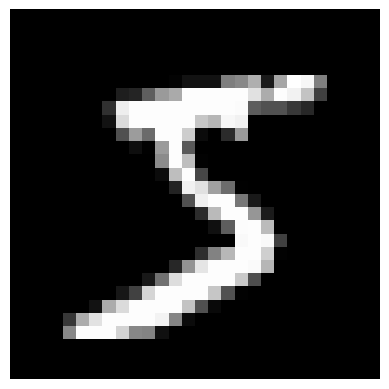

In [373]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())

image, label = mnist_dataset[0]
print("Label:" , label)

plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off") 
plt.show()

## b) Implement sigmoid and ReLU layers

In [374]:
import numpy as np

class SigmoidLayer:
    def __init__(self):
        pass
    
    def forward_pass(self, x):
        self.activation_output = 1 / (1 + np.exp(-x))
        return self.activation_output
    
    def backward_pass(self, activation):
        return (1 - activation) * activation
    

class ReLULayer:
    def __init__(self):
        self.epsilon = 1e-7  #small val so not exact 0
        
    def forward_pass(self, x):
        self.output = np.maximum(self.epsilon, x)
        return self.output
    
    def backward_pass(self, activation):
        return np.where(activation > self.epsilon, 1.0, 0.0)

## c) Implement softmax layer

The goal of the softmax layer is to convert raw scores (logits) from the neural network into probabilites that sum to 1.

Here is the softmax formula: $ f(z)_i = \frac{(e^z)_i}{\Sigma_j^K(e^z)_j} $

In [375]:
import numpy as np
    
class SoftmaxLayer:
    def __init__(self):
        pass
    
    def forward_pass(self, inputs):
        #make sure the dimensions are correct shape
        if inputs.ndim == 1:
            inputs = inputs.reshape(-1, 1)

        #for numerical stability
        epsilon = 1e-7 #dont use exact zero
        shifted_inputs = inputs - np.max(inputs, axis=0, keepdims=True)
        exp_values = np.clip(np.exp(shifted_inputs), epsilon, 1e30) #prevent overflow by clipping if too large
        #normalise
        probabilities = exp_values / np.sum(exp_values, axis=0, keepdims=True)
        return probabilities
    
    def backward_pass(self, activation):
        #cross entropy loss
        return activation

## d) Implement dropout

The goal of the dropout layer is to improve the model's generalization and reduce overfitting by randomly temporarily disabling a fraction of the neurons during training, to prevent the model over-relying on specific neurons

In [376]:
import numpy as np

class DropoutLayer:
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward_pass(self, inputs, training=True):
        if not training or self.rate == 0:
            return inputs
        self.mask = (np.random.rand(*inputs.shape) > self.rate) / (1 - self.rate)
        return inputs * self.mask
    
    def backward_pass(self, gradient):
        return gradient * self.mask

## e) Implement a fully parametrizable neural network class

Feedforward neural network
You should implement a fully-connected NN class where with number of hidden
layers, units, activation functions can be changed. In addition, you can add dropout or
regularizer (L1 or L2). 


Report the parameters used (update rule, learning rate, decay,
epochs, batch size) and include the plots in your report.

## f) Implement optimizer

I will be implementing stochastic gradient descent, mini batch descent and momentum batch descent in addition to the default batch descent already present, this will require changing the train() method of the nn class to make it fully parameterizable but I will make the classes for it here based on an interface class

In [377]:
class Optimizer: #this is like an interface class so i will use the notimplemented error exception because update needs to be done by all the optimizers
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def initialize(self, weights, biases): #only needs to be done by momentum for the velocities
        pass
    
    def update(self, weights, biases, weight_gradients, bias_gradients):
        #update botth the weights and the bias vectors that we get from backpropagation
        raise NotImplementedError

    def should_update_per_sample(self):
        #basically a boolean to see if the weights and biases should be updated every sample - for sgd
        return False

class Batch(Optimizer):
    #basic full batch gradient descent just taken from the original train method
    def update(self, weights, biases, weight_gradients, bias_gradients):
        updated_weights = []
        updated_biases = []

        #my gradients were exploding causing them to overflow and become nan
        max_grad_norm = 1.0
        #norm of sum of gradients 
        grad_norm = np.sqrt(sum([np.sum(grad**2) for grad in weight_gradients]))
        
        #clip if the norm is too big
        if grad_norm > max_grad_norm:
            scale = max_grad_norm / (grad_norm + 1e-7)
            weight_gradients = [grad * scale for grad in weight_gradients]
            bias_gradients = [grad * scale for grad in bias_gradients]

        #use zip its the same effect as doing for i in range(len(self.weights)) and referencing the ith elem but is cleaner imo
        for w, b, w_grad, b_grad in zip(weights, biases, weight_gradients, bias_gradients):
            updated_w = w - self.learning_rate * w_grad
            updated_b = b - self.learning_rate * np.sum(b_grad, axis=1, keepdims=True)
            
            updated_weights.append(updated_w)
            updated_biases.append(updated_b)
            
        return updated_weights, updated_biases

class SGD(Optimizer):
    def should_update_per_sample(self):
        #sgd updates the weights after each sample becuase it can lead to quicker convergence
        return True
    
    def update(self, weights, biases, weight_gradients, bias_gradients):
        #updates weights and biases using SGD - we update immediately using the gradients from a single sample, so no need to average or accumulate gradients
        
        updated_weights = []
        updated_biases = []

        max_grad_norm = 1.0
        grad_norm = np.sqrt(sum([np.sum(grad**2) for grad in weight_gradients]))
        
        if grad_norm > max_grad_norm:
            scale = max_grad_norm / (grad_norm + 1e-7)
            weight_gradients = [grad * scale for grad in weight_gradients]
            bias_gradients = [grad * scale for grad in bias_gradients]
        
        for w, b, w_grad, b_grad in zip(weights, biases, weight_gradients, bias_gradients):
            #direct update
            updated_w = w - self.learning_rate * w_grad
            updated_b = b - self.learning_rate * b_grad
            
            updated_weights.append(updated_w)
            updated_biases.append(updated_b)
            
        return updated_weights, updated_biases

class Momentum(Optimizer):

    def __init__(self, learning_rate, momentum=0.9):
        super().__init__(learning_rate)
        self.momentum = momentum
        self.velocity_w = None
        self.velocity_b = None
        
    def initialize(self, weights, biases):
        #initial velocities are zero 
        self.velocity_w = [np.zeros_like(w) for w in weights]
        self.velocity_b = [np.zeros_like(b) for b in biases]
    
    def update(self, weights, biases, weight_gradients, bias_gradients):
        updated_weights = []
        updated_biases = []
        
        max_norm = 1.0
        total_norm = np.sqrt(sum(np.sum(grad**2) for grad in weight_gradients))
        
        if total_norm > max_norm:
            scale = max_norm / (total_norm + 1e-7)
            weight_gradients = [grad * scale for grad in weight_gradients]
            bias_gradients = [grad * scale for grad in bias_gradients]

        for i, (w, b, w_grad, b_grad) in enumerate(zip(weights, biases, weight_gradients, bias_gradients)):
            #update the velocities every step
            self.velocity_w[i] = self.momentum * self.velocity_w[i] - self.learning_rate * w_grad
            self.velocity_b[i] = self.momentum * self.velocity_b[i] - self.learning_rate * np.sum(b_grad, axis=1, keepdims=True)
            
            updated_w = w + self.velocity_w[i]
            updated_b = b + self.velocity_b[i]
            
            updated_weights.append(updated_w)
            updated_biases.append(updated_b)
            
        return updated_weights, updated_biases #will become the nn class new self.weights and self.biases

class MiniBatch(Optimizer):
    def __init__(self, learning_rate, batch_size=32):
        super().__init__(learning_rate)
        self.batch_size = batch_size #now we can deal with smaller batches
        
    def get_batches(self, input_data, target_data):
        #create the batches 
        n_samples = len(input_data)
        indices = np.random.permutation(n_samples) #init the random batch indexes to know where is the start and end 
        
        batch_starts = range(0, n_samples, self.batch_size)
        
        batches = []
        for start in batch_starts:
            end = min(start + self.batch_size, n_samples)
            batch_indices = indices[start:end]
            
            input_batch = input_data[batch_indices]
            target_batch = target_data[batch_indices]
            
            batches.append((input_batch, target_batch))
            
        return batches
    
    def update(self, weights, biases, weight_gradients, bias_gradients):
        updated_weights = []
        updated_biases = []

        #for mini batch its done on the MEAN of the gradients same as list comprehension way above but we take the mean instrad
        w_grads_mean = []
        b_grads_mean = []

        for w_grad in weight_gradients:
            if isinstance(w_grad, list):
                mean_gradient = np.mean(w_grad, axis=0)
            else:
                mean_gradient = w_grad
            w_grads_mean.append(mean_gradient)

        for b_grad in bias_gradients:
            if isinstance(b_grad, list):
                mean_gradient = np.mean(b_grad, axis=1, keepdims=True)
            else:
                mean_gradient = b_grad
            b_grads_mean.append(mean_gradient)
        
        #clip the means
        max_norm = 1.0
        total_norm = np.sqrt(sum(np.sum(grad**2) for grad in w_grads_mean))
        
        if total_norm > max_norm:
            scale = max_norm / (total_norm + 1e-7)
            w_grads_mean = [grad * scale for grad in w_grads_mean]
            b_grads_mean = [grad * scale for grad in b_grads_mean]
        
        #update w the clipped gradients
        for w, b, w_grad, b_grad in zip(weights, biases, w_grads_mean, b_grads_mean):
            updated_w = w - self.learning_rate * w_grad
            updated_b = b - self.learning_rate * b_grad
            
            updated_weights.append(updated_w)
            updated_biases.append(updated_b)
            
        return updated_weights, updated_biases

In [378]:
import numpy as np
from scipy.stats import truncnorm

class NeuraNetwork:
    
     def __init__(self, in_nodes, out_nodes, hidden_layers, hidden_activation, output_activation, dropoutRate=0.0, learning_rate=0.001, regularization=None, lambda_=0.01, epochs=100, optimizer='bgd', batch_size=32, decay_rate=0.95, decay_steps=5, min_lr=1e-5):
        # Intialises the neural network 
        #Parameters
        # inNodes: number of input nodes
        # outNodes: number of output nodes
        # hidden_layers: list of number of neurons in each hidden layer. eg [128, 64, 32]
        # hidden_activation: activation function (uses the forward_pass and backward_pass methods) for hidden layers
        # output_activation: activation function for output layer 
        # dropoutRate: dropout rate to reduce overfitting
        # learning_rate: learning rate for training
        # regularization: type of regularization l1 or l2
        # lambda_: regularization strength
        # epochs : the number of epochs that will run over the set
        # optimizer : the selected optimizer out of bdg, sgd, minibgd, momentum
        # batch_size : size for minibatch optimiser
        # decay_rate : rate that the learning rate decays by (decrease the learning rate as we get closer to convergence)
        # decay-steps : amount of step intervals we should apply the decay rate
        # min_lr : the smallest learning rate that will be used throught training
    
        self.in_nodes = in_nodes
        self.out_nodes = out_nodes
        self.hidden_layers = hidden_layers
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.dropoutRate = dropoutRate
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.lambda_ = lambda_
        self.epochs = epochs
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.min_lr = min_lr
        self.create_weight_matrices()
        self.dropout = DropoutLayer(self.dropoutRate)

        if(self.optimizer == "bgd"):
            self.optimizer = Batch(self.learning_rate)
        elif(self.optimizer == "sgd"):
            self.optimizer = SGD(self.learning_rate)
        elif(self.optimizer == "minibgd"):
            self.optimizer = MiniBatch(self.learning_rate, self.batch_size)
        elif(self.optimizer == "momentum"):
            self.optimizer == Momentum(self.learning_rate)
        else:
            raise Exception("invalid optimizer choice")

     def truncated_normal(self, mean=0, sd=1, low=0, upp=10):
        return truncnorm(
            (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
        #Truncated distribution with a specified mean, standard diviation, and bounds

     def create_weight_matrices(self):
        """method to initialize the weight matrices of the neural network"""
        self.weights = []
        self.biases = []

        '''
        #init input to first hiddn layer - make it random so its not all zeroes
        rad = 1 / np.sqrt(self.in_nodes) #type of xavier init - to prevent activations and gradients from growing in a exponential way between layers
        X = self.truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        w1 = (X.rvs((self.hidden_layers[0], self.in_nodes))) #initial dimensions is num of neurons in first hidden layer by amount of features
        self.weights.append(w1 / np.sqrt(np.sum(w1 * w1)))  #normalise the wieght
        self.biases.append(np.zeros((self.hidden_layers[0], 1))) #inital bias col vector 
        
        #init hidden layer to next hidden layer for all hidden layers
        for i in range(1, len(self.hidden_layers)):
            rad = 1 / np.sqrt(self.hidden_layers[i-1])
            X = self.truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
            w = (X.rvs((self.hidden_layers[i], self.hidden_layers[i-1])))
            self.weights.append(w / np.sqrt(np.sum(w * w))) #normalise
            self.biases.append(np.zeros((self.hidden_layers[i], 1)))

        #init last layer to output layer
        rad = 1 / np.sqrt(self.hidden_layers[-1])
        X = self.truncated_normal(mean=0, sd=1, low=-rad, upp=rad)
        w_out = (X.rvs((self.out_nodes, self.hidden_layers[-1]))) #init dimension for output layer
        self.weights.append(w_out / np.sqrt(np.sum(w_out * w_out))) #normalise
        self.biases.append(np.zeros((self.out_nodes, 1)))
        '''
        '''
       # Adding a scaling factor to make initialization more conservative
        conservative_factor = 0.01
    
        # Input to first hidden layer
        scale = conservative_factor * np.sqrt(2.0 / self.in_nodes)
        self.weights.append(np.random.randn(self.hidden_layers[0], self.in_nodes) * scale)
        self.biases.append(np.zeros((self.hidden_layers[0], 1)))
        
        # Hidden layers
        for i in range(1, len(self.hidden_layers)):
            scale = conservative_factor * np.sqrt(2.0 / self.hidden_layers[i-1])
            self.weights.append(np.random.randn(self.hidden_layers[i], self.hidden_layers[i-1]) * scale)
            self.biases.append(np.zeros((self.hidden_layers[i], 1)))
        
        # Output layer
        scale = conservative_factor * np.sqrt(2.0 / self.hidden_layers[-1])
        self.weights.append(np.random.randn(self.out_nodes, self.hidden_layers[-1]) * scale)
        self.biases.append(np.zeros((self.out_nodes, 1)))
        '''
        
        #back to xavier
        fan_in = self.in_nodes
        lim = 1 / np.sqrt(fan_in)
        W1 = np.random.uniform(-lim, lim, size=(self.hidden_layers[0], fan_in))
        self.weights.append(W1)
        self.biases.append(np.zeros((self.hidden_layers[0], 1))) 

        for i in range(1, len(self.hidden_layers)):
            fan_in = self.hidden_layers[i-1]
            lim = 1 / np.sqrt(fan_in)
            W = np.random.uniform(-lim, lim, size=(self.hidden_layers[i], fan_in))
            self.weights.append(W)
            self.biases.append(np.zeros((self.hidden_layers[i], 1)))

        fan_in = self.hidden_layers[-1]
        lim = 1 / np.sqrt(fan_in)
        W_out = np.random.uniform(-lim, lim, size=(self.out_nodes, fan_in))
        self.weights.append(W_out)
        self.biases.append(np.zeros((self.out_nodes, 1)))
            
     def apply_regularization(self, weights):
            """applies L1 or L2 regularization."""
            if self.regularization == 'L1':
                return self.lambda_ * np.sign(weights)
            elif self.regularization == 'L2':
                return self.lambda_ * weights
            return 0   
     
     def monitor_weights(self):
        """monitor weight statistics with layer-specific thresholds"""
        for i, w in enumerate(self.weights):
            if np.any(np.isnan(w)):
                print(f"layer {i} weights contain NaN values!!!")
                return False
            
            magnitude = np.sqrt(np.mean(w * w))#mean sum for better scaling
            threshold = 2.0
            
            if magnitude > threshold:
                print(f"layer {i} weights RMS magnitude ({magnitude:.4f}) is too large")
                return False
        
        return True
     

     def forward_pass(self, input_vector, training=True):
        """perform a forward pass, each layer has its own weights and bias matrices as init above"""

        if not self.monitor_weights():
            raise ValueError("weight instability detected!")
     
        activations = [input_vector] #init the activations list to be the input vector 
        for i in range(len(self.weights) -1 ): #for each layer in the nn up to output layer
            #calculate the z value of the neuron which is the dot product of This Layer's weights and the activations of the previous layer added with bias col vector [Z = W(L) * a(L-1) + b(L)]
            z = np.dot(self.weights[i], activations[-1]) + self.biases[i] 

            if np.any(np.isnan(z)):
                print(f"NaN detected after layer {i} weights multiplication")
                print(f"Weight stats - min: {np.min(self.weights[i])}, max: {np.max(self.weights[i])}")
                print(f"Previous activation stats - min: {np.min(activations[-1])}, max: {np.max(activations[-1])}")

            a = self.hidden_activation.forward_pass(z) #calc the activation value with forward_pass method of the activation func sigmoid or ReLU or softMax
            if training and self.dropoutRate > 0:
                a = self.dropout.forward_pass(a, training) #apply dropout mask if training
            activations.append(a) #update the list of activations, the final nn output is activations[-1] 
        
        #output layer activations
        z_final = np.dot(self.weights[-1], activations[-1]) + self.biases[-1]
        a_final = self.output_activation.forward_pass(z_final)
        activations.append(a_final)

        return activations
    

     def backpropagation(self, activations, target_vector):
        """perform backward pass to compute gradients"""
        error = [target_vector - activations[-1]] #error for each layer 
        gradients_w = []
        gradients_b = []

        #starting from the final layer back to the first layer 
        for i in reversed(range(len(self.weights))):
            error[-1] = np.clip(error[-1], -1.0, 1.0) #clip to prevent extrme 
            #ok so derivative of output error with respect to weight dL/dW(L) = (a(L) - y) * a(L)(1-a(L)) * a(L-1) (in the case of sigmoid)
            #error[-1] contains (a(L) - y)
            #so we multiply it by the derivative of the activation function a(L)(1-a(L)) for sigmoid 
            #so delta = dL/dZ = dL/dA * dA/dZ. 
            if i == len(self.weights) - 1:  #the output layer is first 
                delta = error[-1] * self.output_activation.backward_pass(activations[i+1])
            else:
                delta = error[-1] * self.hidden_activation.backward_pass(activations[i+1])
            
            #to get the gradient dL/dw(L) we need to multiply dL/dZ (delta) by dZ(L)/dW(L). Which is same as delta * a(L-1) as well as any regularization that prevents overfitting
            current_gradient = np.dot(delta, activations[i].T) + self.apply_regularization(self.weights[i])
            grad_norm = np.sqrt(np.sum(current_gradient * current_gradient))
            if grad_norm > 1.0:  # If gradient magnitude is too large
                current_gradient = current_gradient / (grad_norm + 1e-7)
            gradients_w.append(current_gradient)
            gradients_b.append(delta) # dL/db(L) = dL/dZ(L) * dZ(L)/db(L) = delta * 1 = delta
            
            if i > 0:
                backward_error = np.dot(self.weights[i].T, delta)
                error_norm = np.sqrt(np.sum(backward_error * backward_error)) #prevent it growing too large
                if error_norm > 1.0:
                    backward_error = backward_error / (error_norm + 1e-7)
                error.append(backward_error)


        gradients_w.reverse()
        gradients_b.reverse()
        return gradients_w, gradients_b

     def train(self, input_data, target_data):
        """
        train with basic gradient descent over given number of epoches
        """
        input_data = np.array(input_data)
        target_data = np.array(target_data)

        #keep track of statistics from training  - using list for each one so i can graph it later
        history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'learning_rate': [] 
        }

        initial_lr = self.optimizer.learning_rate #inital learning rate is one we specifed, this wil change as decay happnes

        #init the optimiser if its momentum - will do nothing if its a different optimiser
        self.optimizer.initialize(self.weights, self.biases)

        for epoch in range(self.epochs):
            #applying the learning rate decay formula
            current_lr = initial_lr * (self.decay_rate ** (epoch // self.decay_steps))
            current_lr = max(current_lr, self.min_lr)  #make sure it does not go below the min lr 
            self.optimizer.learning_rate = current_lr

            epoch_loss = 0
            n_samples = 0
            correct_predictions = 0

            #prep and init the batches if we are using mini batch otherwise apply over whole batch
            if isinstance(self.optimizer, MiniBatch):
                batches = self.optimizer.get_batches(input_data, target_data)
            else:
                batches = [(input_data, target_data)]
            
            #for every batch (only 1 in case that we arent using minibatch)
            for batch_input, batch_target in batches:
                batch_size = len(batch_input)
                n_samples += batch_size
                
                #init the gradients (if we arent using sgd)
                batch_grad_w = [np.zeros_like(w) for w in self.weights]
                batch_grad_b = [np.zeros_like(b) for b in self.biases]
                
                #do a full forward pass and backpropagation and update the weights for each batch/sample
                for i in range(batch_size):
                    #make sure theyre in the correct dimensions
                    input_vector = np.expand_dims(batch_input[i], axis=1)
                    target_vector = np.expand_dims(batch_target[i], axis=1)
                    
                    #do the forward pass
                    activations = self.forward_pass(input_vector, training=True)
                    
                    #calc cross-entropy loss
                    epsilon = 1e-15
                    output = np.clip(activations[-1], epsilon, 1 - epsilon)
                    loss = -np.sum(target_vector * np.log(output))
                    epoch_loss += loss
                    
                    #track the accuracy
                    predicted = np.argmax(activations[-1])
                    true_label = np.argmax(target_vector)
                    if predicted == true_label:
                        correct_predictions += 1
                    
                    #backpropagation
                    gradients_w, gradients_b = self.backpropagation(activations, target_vector)
                    
                    if self.optimizer.should_update_per_sample():
                        #update weights directly for sgd after each sample
                        self.weights, self.biases = self.optimizer.update(
                            self.weights, self.biases, gradients_w, gradients_b
                        )
                    else:
                        #for the other optimizers we update our batch gradient
                        for j in range(len(self.weights)):
                            batch_grad_w[j] += gradients_w[j]
                            batch_grad_b[j] += gradients_b[j]
                
                #update each layers weights (non sgd)
                if not self.optimizer.should_update_per_sample():
                    self.weights, self.biases = self.optimizer.update(
                        self.weights, self.biases, batch_grad_w, batch_grad_b
                    )
            
            #calc loss and accuracy
            avg_loss = epoch_loss / n_samples
            accuracy = (correct_predictions / n_samples) * 100
            
            #add it to the metric history
            history['loss'].append(avg_loss)
            history['accuracy'].append(accuracy)
            history['learning_rate'].append(current_lr)
            
            print(f"epoch {epoch + 1}/{self.epochs} - loss: {avg_loss} - accuracy: {accuracy}% - LR: {current_lr}")
        
        return history
    
            
     def run(self, input_data, targets=None):
        """
        prediction method, does a forward pass through the network on the input vector and returns the final activation vector
        """
        #make sure the input vector dimensions correct format
        if input_data.ndim == 1:
            input_data = np.expand_dims(input_data, axis=0)
        
        batch_size = len(input_data)
        predictions = []
        metrics = {'loss': 0, 'accuracy': 0} if targets is not None else None
        
        for i in range(batch_size):
            input_vector = np.expand_dims(input_data[i], axis=1)
            
            #forward pass (no dropout during testing)
            activations = [input_vector]
            for j in range(len(self.weights)):
                z = np.dot(self.weights[j], activations[-1]) + self.biases[j]
                a = self.hidden_activation.forward_pass(z) if j < len(self.weights)-1 else self.output_activation.forward_pass(z)
                activations.append(a)
            
            predictions.append(activations[-1])
            
            #calc metrics
            if targets is not None:
                target_vector = np.expand_dims(targets[i], axis=1)
                
                #cross-entropy loss
                epsilon = 1e-15
                output = np.clip(activations[-1], epsilon, 1 - epsilon)
                loss = -np.sum(target_vector * np.log(output))
                metrics['loss'] += loss
                
                #accuracy
                predicted = np.argmax(activations[-1])
                true_label = np.argmax(target_vector)
                metrics['accuracy'] += (predicted == true_label)
        
        predictions = np.array(predictions).squeeze()
        if metrics is not None:
            metrics['loss'] /= batch_size
            metrics['accuracy'] = (metrics['accuracy'] / batch_size) * 100
        
        if metrics is not None:
            return (predictions, metrics)
        else:
            return predictions

## Initial Tests

This test was performed before implementing optimisers as seperate class and so it was just done with vanilla batch gradient descent

Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.
Epoch 20/20 - Loss: 1.8393 - Accuracy: 34.13%
Predicted class: 7

Probability distribution:
Class 0: 0.9983
Class 1: 0.9932
Class 2: 0.9989
Class 3: 0.9991
Class 4: 0.9994
Class 5: 0.9990
Class 6: 0.9991
Class 7: 0.9996
Class 8: 0.9990
Class 9: 0.9995

True label: 7


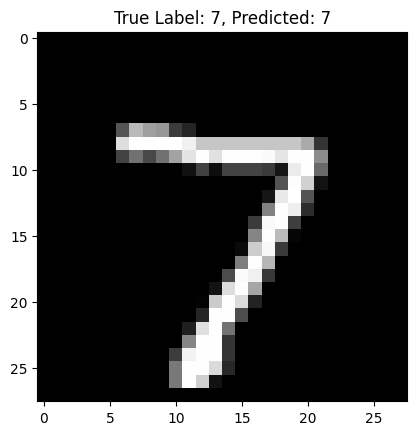

'\n# Evaluate on binary classification test set\ncorrect = 0\nfor i in range(len(binary_test_images)):\n    output = nn.run(binary_test_images[i])\n    predicted_class = 1 if output >= 0.5 else 0\n    if predicted_class == binary_test_labels[i]:\n        correct += 1\n\naccuracy = correct / len(binary_test_images)\nprint(f"Accuracy on binary classification test set: {accuracy * 100:.2f}%")\n'

In [239]:

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_images = mnist_train.data.numpy().reshape(-1, 28*28) / 255.0  #[0, 1]
train_labels = mnist_train.targets.numpy()

test_images = mnist_test.data.numpy().reshape(-1, 28*28) / 255.0
test_labels = mnist_test.targets.numpy()

def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_one_hot = one_hot_encode(train_labels)
test_labels_one_hot = one_hot_encode(test_labels)

sigmoid = SigmoidLayer()
softmax = SoftmaxLayer()

nn = NeuraNetwork(
    in_nodes=784,             #28x28 pixels flattened
    out_nodes=10,             #10 digits
    hidden_layers=[128, 64],  #two hidden layers
    hidden_activation=sigmoid,    #sigmoid for hidden layers
    output_activation=softmax,    #softmax for output layer
    dropoutRate=0.2,
    learning_rate=0.001,
    epochs=20
)

nn.train(train_images, train_labels_one_hot)


test_sample = test_images[0]
output = nn.run(test_sample)
probabilities = output.flatten()  #convert to normal array
predicted_class = np.argmax(probabilities)

print("Predicted class:", predicted_class)
print("\nProbability distribution:")
for i, prob in enumerate(probabilities):
    print(f"Class {i}: {prob:.4f}")
print(f"\nTrue label: {test_labels[0]}")

import matplotlib.pyplot as plt
plt.imshow(test_images[0].reshape(28, 28), cmap='gray')
plt.title(f"True Label: {test_labels[0]}, Predicted: {predicted_class}")
plt.show()


Epoch 1/20 completed.
Epoch 2/20 completed.
Epoch 3/20 completed.
Epoch 4/20 completed.
Epoch 5/20 completed.
Epoch 6/20 completed.
Epoch 7/20 completed.
Epoch 8/20 completed.
Epoch 9/20 completed.
Epoch 10/20 completed.
Epoch 11/20 completed.
Epoch 12/20 completed.
Epoch 13/20 completed.
Epoch 14/20 completed.
Epoch 15/20 completed.
Epoch 16/20 completed.
Epoch 17/20 completed.
Epoch 18/20 completed.
Epoch 19/20 completed.
Epoch 20/20 completed.
Epoch 20/20 - Loss: 2.3012 - Accuracy: 11.24%
Predicted class: 1

Probability distribution:
Class 0: 0.0988
Class 1: 0.1119
Class 2: 0.0995
Class 3: 0.1022
Class 4: 0.0973
Class 5: 0.0905
Class 6: 0.0985
Class 7: 0.1046
Class 8: 0.0978
Class 9: 0.0989

True label: 7


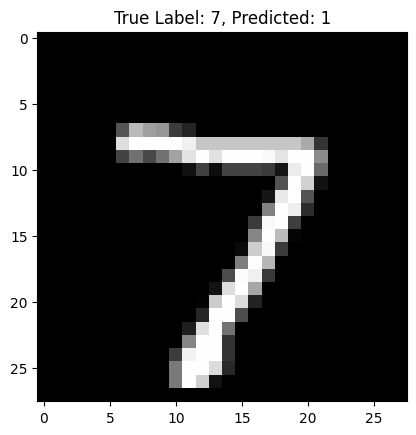

In [240]:
nn2 = NeuraNetwork(
    in_nodes=784,             #28x28 pixels flattened
    out_nodes=10,             #10 digits
    hidden_layers=[128, 64],  #Two hidden layers
    hidden_activation=softmax,    #softmax for hidden layers
    output_activation=softmax,    #softmax for output layer
    dropoutRate=0.2,
    learning_rate=0.001,
    epochs=20
)

nn2.train(train_images, train_labels_one_hot)


test_sample = test_images[0]
output = nn2.run(test_sample)
probabilities = output.flatten()  
predicted_class = np.argmax(probabilities)

print("Predicted class:", predicted_class)
print("\nProbability distribution:")
for i, prob in enumerate(probabilities):
    print(f"Class {i}: {prob:.4f}")
print(f"\nTrue label: {test_labels[0]}")


import matplotlib.pyplot as plt
plt.imshow(test_images[0].reshape(28, 28), cmap='gray')
plt.title(f"True Label: {test_labels[0]}, Predicted: {predicted_class}")
plt.show()

## g) Evaluate different neural network architectures/parameters, present and discuss your results. 

These are the tests conducted after the optimizer class was added and made paramaterisable

In [367]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=ToTensor())

train_images = mnist_train.data.numpy().reshape(-1, 28*28) / 255.0
train_labels = mnist_train.targets.numpy()
test_images = mnist_test.data.numpy().reshape(-1, 28*28) / 255.0
test_labels = mnist_test.targets.numpy()

val_size = len(train_images) // 10
val_images = train_images[:val_size]
val_labels = train_labels[:val_size]
train_images = train_images[val_size:]
train_labels = train_labels[val_size:]

def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_one_hot = one_hot_encode(train_labels)
val_labels_one_hot = one_hot_encode(val_labels)
test_labels_one_hot = one_hot_encode(test_labels)

#this will be my baseline
nn = NeuraNetwork(
    in_nodes=784,  # 28*28 pixel input
    out_nodes=10,  # 10 classes (digits 0-9)
    hidden_layers=[128, 64, 32],
    hidden_activation=ReLULayer(),
    output_activation=SoftmaxLayer(),
    dropoutRate=0.1,
    learning_rate=0.001,
    optimizer='minibgd', 
    batch_size=64,
    epochs=50,
    decay_rate=0.95,
    decay_steps=5,
    min_lr=1e-6,  
    regularization='L2',
    lambda_=0.001
)

print("starting training...")
history = nn.train(train_images, train_labels_one_hot)

plt.figure(figsize=(15, 5))

#loss
plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='Training Loss')
if 'val_loss' in history:
    plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#accuracy
plt.subplot(1, 3, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history:
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.legend()

#learning rate
plt.subplot(1, 3, 3)
plt.plot(history['learning_rate'])
plt.title('Learning Rate Over Time')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()

#test set eval
print("\nEvaluating on test set...")
test_predictions, test_metrics = nn.run(test_images, test_labels_one_hot)
print(f"Test Set Performance:")
print(f"Loss: {test_metrics['loss']:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.2f}%")

num_samples = 5
plt.figure(figsize=(15, 3))

for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    
    #single sample prediction
    test_sample = test_images[i]
    predictions = nn.run(test_sample)
    predicted_class = np.argmax(predictions)
    true_class = np.argmax(test_labels_one_hot[i])
    
    plt.imshow(test_sample.reshape(28, 28), cmap='gray')
    plt.title(f'Pred: {predicted_class}\nTrue: {true_class}')
    plt.axis('off')

plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns
test_subset = test_images[:1000]
predictions_subset = nn.run(test_subset)
predicted_classes = np.argmax(predictions_subset, axis=1)
true_classes = np.argmax(test_labels_one_hot[:1000], axis=1)

#confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#metrics
print("\nDetailed metrics for each digit:")
for digit in range(10):
    mask = true_classes == digit
    digit_acc = (predicted_classes[mask] == true_classes[mask]).mean() * 100
    print(f"Digit {digit} accuracy: {digit_acc:.2f}%")

starting training...
epoch 1/50 - loss: 2.3114010982214124 - accuracy: 9.037037037037036% - LR: 0.001
epoch 2/50 - loss: 2.3378488030335367 - accuracy: 9.074074074074074% - LR: 0.001
epoch 3/50 - loss: 2.4558242091737577 - accuracy: 5.4185185185185185% - LR: 0.001
epoch 4/50 - loss: 4.781972400877047 - accuracy: 8.540740740740741% - LR: 0.001
epoch 5/50 - loss: 12.718417772736508 - accuracy: 11.242592592592594% - LR: 0.001
epoch 6/50 - loss: 14.303060597107505 - accuracy: 11.242592592592594% - LR: 0.00095
epoch 7/50 - loss: 14.306004723238194 - accuracy: 11.242592592592594% - LR: 0.00095
epoch 8/50 - loss: 14.306004723235612 - accuracy: 11.242592592592594% - LR: 0.00095
epoch 9/50 - loss: 14.306004723235613 - accuracy: 11.242592592592594% - LR: 0.00095
epoch 10/50 - loss: 14.30600472323561 - accuracy: 11.242592592592594% - LR: 0.00095
epoch 11/50 - loss: 14.306004723235604 - accuracy: 11.242592592592594% - LR: 0.0009025
epoch 12/50 - loss: 14.306004723235606 - accuracy: 11.242592592592

KeyboardInterrupt: 